# Cahn-Hilliard Example

This example demonstrates how to use PyMKS to solve the Cahn-Hilliard equation. The first section provides some background information about the Cahn-Hilliard equation as well as details about calibrating and validating the MKS model. The example demonstrates how to generate sample data, calibrate the influence coefficients and then pick an appropriate number of local states when state space is continuous. The MKS model and a spectral solution of the Cahn-Hilliard equation are compared on a larger test microstructure over multiple time steps.

### Cahn-Hilliard Equation

The Cahn-Hilliard equation is used to simulate microstructure evolution during spinodial decomposition and has the following form,

$$ \dot{\phi} = \nabla^2 \left( \phi^3 - \phi \right) - \gamma \nabla^4 \phi $$

where $\phi$ is a conserved ordered parameter and $\sqrt{\gamma}$ represents the width of the interface. In this example, the Cahn-Hilliard equation is solved using a semi-implicit spectral scheme with periodic boundary conditions, see  [Chang and Rutenberg](http://dx.doi.org/10.1103/PhysRevE.72.055701) for more details.

In [1]:
import pymks

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt


## Modeling with MKS

In this example the MKS equation will be used to predict microstructure at the next time step using 

$$p[s, 1] = \sum_{r=0}^{S-1} \alpha[l, r, 1] \sum_{l=0}^{L-1} m[l, s - r, 0] + ...$$

where $p[s, n + 1]$ is the concentration field at location $s$ and at time $n + 1$, $r$ is the convolution dummy variable and $l$ indicates the local states varable. $\alpha[l, r, n]$ are the influence coefficients and $m[l, r, 0]$ the microstructure function given to the model. $S$ is the total discretized volume and $L$ is the total number of local states `n_states` choosen to use.

The model will march forward in time by recursively replacing discretizing $p[s, n]$ and substituing it back for $m[l, s - r, n]$.

### Calibration Datasets

Unlike the elastostatic examples, the microstructure (concentration field) for this simulation doesn't have discrete phases. The microstructure is a continuous field that can have a range of values which can change over time, therefore the first order influence coefficients cannot be calibrated with delta microstructures. Instead, a large number of simulations with random initial conditions are used to calibrate the first order influence coefficients using linear regression.

The function `make_cahn_hilliard` from `pymks.datasets` provides an interface to generate calibration datasets for the influence coefficients. To use `make_cahn_hilliard`, we need to set the number of samples we want to use to calibrate the influence coefficients using `n_samples`, the size of the simulation domain using `size` and the time step using `dt`.

In [2]:
import pymks
from pymks.datasets import make_cahn_hilliard

n = 41
n_samples = 400
dt = 1e-2
np.random.seed(99)
X, y = make_cahn_hilliard(n_samples=n_samples, size=(n, n), dt=dt)


The function `make_cahnHilliard` generates `n_samples` number of random microstructures, `X`, and the associated updated microstructures, `y`, after one time step `y`. The following cell plots one of these microstructures along with its update.

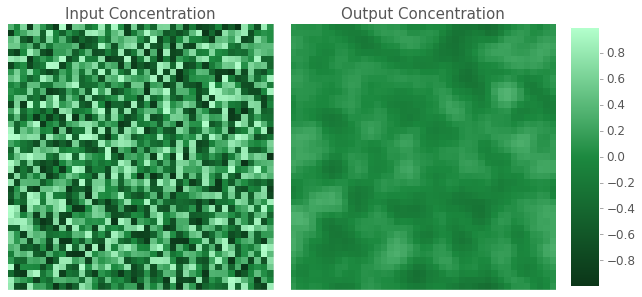

In [3]:
from pymks.tools import draw_concentrations

draw_concentrations((X[0], y[0]), labels=('Input Concentration', 'Output Concentration'))


### Calibrate Influence Coefficients

As mentioned above, the microstructures (concentration fields) does not have discrete phases. This leaves the number of local states in local state space as a free hyperparameter. In previous work it has been shown that, as you increase the number of local states, the accuracy of MKS model increases (see [Fast et al.](http://dx.doi.org/10.1016/j.actamat.2010.10.008)), but, as the number of local states increases, the difference in accuracy decreases. Some work needs to be done in order to find the practical number of local states that we will use. 

### Optimizing the Number of Local States

Let's split the calibrate dataset into test and training datasets. The function `train_test_split` for the machine learning Python module [sklearn](http://scikit-learn.org/stable/) provides a convenient interface to do this. 80% of the dataset will be used for training and the remaining 20% will be used for testing by setting `test_size` equal to 0.2. The state of the random number generator used to make the split can be set using `random_state`.  

In [4]:
import sklearn
from sklearn.cross_validation import train_test_split

split_shape = (X.shape[0],) + (X[0].size,)
X_train, X_test, y_train, y_test = train_test_split(X.reshape(split_shape), y.reshape(split_shape),
                                                    test_size=0.5, random_state=3)


We are now going to calibrate the influence coefficients while varying the number of local states from 2 up to 20. Each of these models will then predict the evolution of the concentration fields. Mean square error will be used to compare the results with the testing dataset to evaluate how the MKS model's performance changes as we change the number of local states.  

First we need to import the class `MKSLocalizationModel` from `pymks`.

In [5]:
from pymks import MKSLocalizationModel
from pymks.bases import PrimitiveBasis


Next we will calibrate the influence coefficients while varying the number of local states and compute the mean squared error. The following demonstrates how to use scikit-learn's `GridSearchCV` to optimize `n_states` as a hyperparameter. Of course, the best fit is always with a larger value of `n_states`. Increasing this parameter does not overfit the data.

In [6]:
from sklearn.grid_search import GridSearchCV

parameters_to_tune = {'n_states': np.arange(2, 11)}
p_basis = PrimitiveBasis(2, [-1, 1])
model = MKSLocalizationModel(p_basis, n_jobs=4)
gs = GridSearchCV(model, parameters_to_tune, cv=5, fit_params={'size': (n, n)})
gs.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=MKSLocalizationModel(basis=<pymks.bases.primitive.PrimitiveBasis object at 0x7f2809547990>,
           lstsq_rcond=2.2204460492503131e-12, n_jobs=None,
           n_states=array([0, 1])),
       fit_params={'size': (41, 41)}, iid=True, n_jobs=1,
       param_grid={'n_states': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [7]:
print(gs.best_estimator_)
print(gs.score(X_test, y_test))


MKSLocalizationModel(basis=<pymks.bases.primitive.PrimitiveBasis object at 0x7f280cbca850>,
           lstsq_rcond=2.2204460492503131e-12, n_jobs=None, n_states=10)
0.99999908222


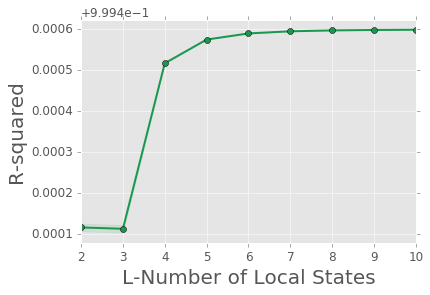

In [8]:
from pymks.tools import draw_gridscores

draw_gridscores(gs.grid_scores_, 'n_states',
                score_label='R-squared', param_label='L-Number of Local States')


As expected, the accuracy of the MKS model monotonically increases, as we increase `n_states`, but accuracy doesn't improve significantly as `n_states` gets larger than signal digits. 

In order to save on computation costs, let's set (calibrate) the influence coefficients with `n_states` equal to 6, but realize that, if we need slightly more accuracy, the value can be increased.

In [9]:
model = MKSLocalizationModel(basis=PrimitiveBasis(6, [-1, 1]))
model.fit(X, y)


Here are the first 4 influence coefficients. 

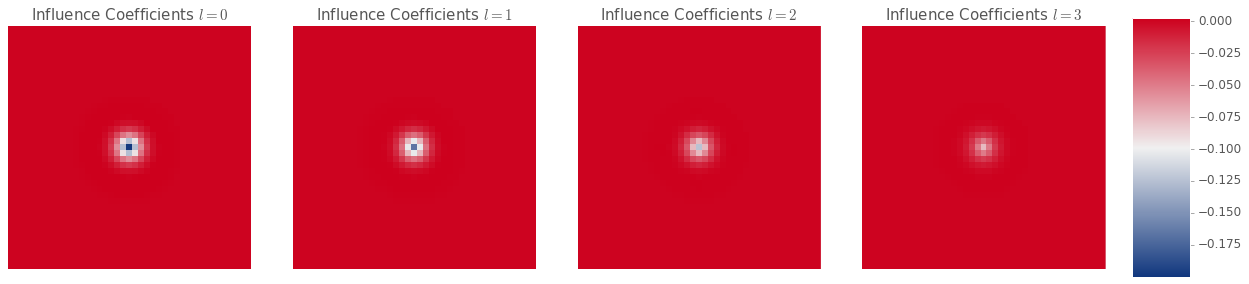

In [10]:
from pymks.tools import draw_coeff

draw_coeff(model.coef_[...,:4])


### Predict Microstructure Evolution

With the calibrated influence coefficients, we are ready to predict the evolution of a concentration field. In order to do this, we need to have the Cahn-Hilliard simulation and the MKS model start with the same initial concentration `phi0` and evolve in time. In order to do the Cahn-Hilliard simulation, we need an instance of the class `CahnHilliardSimulation`.

In [11]:
from pymks.datasets.cahn_hilliard_simulation import CahnHilliardSimulation
np.random.seed(191)

phi0 = np.random.normal(0, 1e-9, (1, n, n))
ch_sim = CahnHilliardSimulation(dt=dt)
phi_sim = phi0.copy()
phi_pred = phi0.copy()


In order to move forward in time, we need to feed the concentration back into the Cahn-Hilliard simulation and the MKS model.

In [12]:
time_steps = 10

for ii in range(time_steps):
    ch_sim.run(phi_sim)
    phi_sim = ch_sim.response
    phi_pred = model.predict(phi_pred)


Let's take a look at the concentration fields.

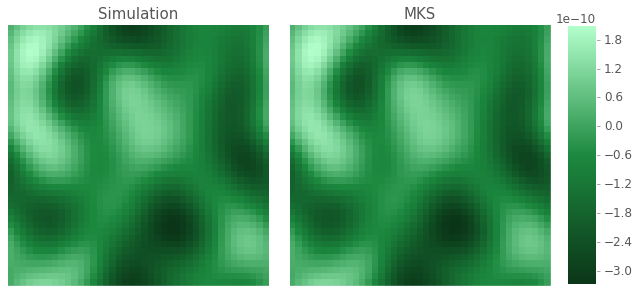

In [13]:
from pymks.tools import draw_concentrations_compare

draw_concentrations((phi_sim[0], phi_pred[0]), labels=('Simulation', 'MKS'))


The MKS model was able to capture the microstructure evolution with 6 local states. 

## Resizing the Coefficients to use on Larger Systems 

Now let's try and predict a larger simulation by resizing the coefficients and provide a larger initial concentratio field.

In [14]:
m = 3 * n
model.resize_coeff((m, m))

phi0 = np.random.normal(0, 1e-9, (1, m, m))
phi_sim = phi0.copy()
phi_pred = phi0.copy()


Once again we are going to march forward in time by feeding the concentration fields back into the Cahn-Hilliard simulation and the MKS model. 

In [15]:
for ii in range(1000):
    ch_sim.run(phi_sim)
    phi_sim = ch_sim.response
    phi_pred = model.predict(phi_pred)


Let's take a look at the results.

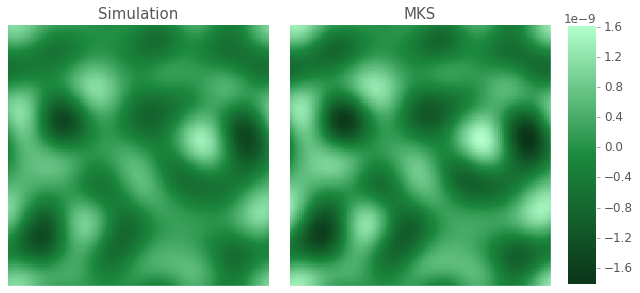

In [16]:
from pymks.tools import draw_concentrations_compare

draw_concentrations_compare((phi_sim[0], phi_pred[0]), labels=('Simulation', 'MKS'))


The MKS model with resized influence coefficients was able to reasonably predict the structure evolution for a larger concentration field. 